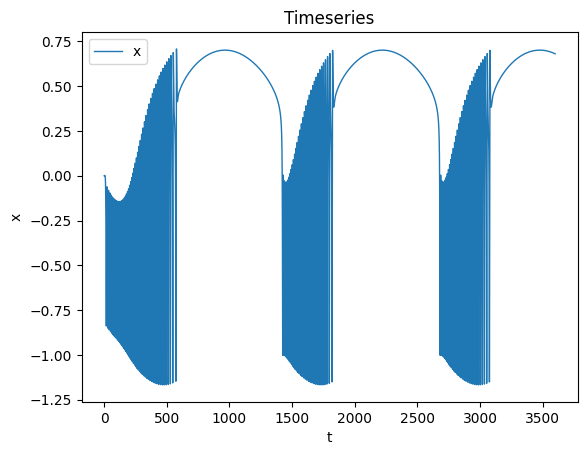

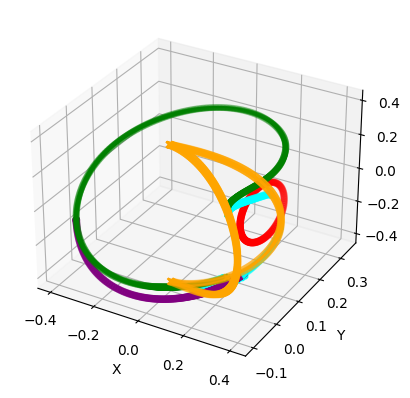

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.io as sio
from sympy import symbols, solve
import trimesh
import math
from scipy.io import loadmat
import random
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def Bifurcation_one_path(I):
    # Load the initial curves2.mat file
    # SHl, SNIC, Hopf, and FLC are the bifurcation curves used for onset/offset
    curves2 = loadmat('curves2.mat')
    SHl = curves2['SHl']
    SNIC = curves2['SNIC']
    Hopf = curves2['Hopf']
    FLC = curves2['FLC']

    # Initialize variables
    onset_curve = None
    offset_curve = None
    offset_curve2 = None
    flag = None

# I corresponds to the seizure class you are generating models for
# The path starts on the onset bifurcation line then it goes through a set point(np.arrary), and then the circular path stops at the offset bifurcation line
# onset_curve and offset_curve/offset_curve2 indicates the bifurcation curves used for onset and offset
# Each I corresponds to a different flag because the set point changes between classes. The set point is either offset_curve or offset_curve 2
# Calculates A,B,C based on the selected curves and flag value

    if I == 1:
        onset_curve = SHl[:, 49:104]
        offset_curve = np.array([0.33, 0.11, 0.18])
        offset_curve2 = SNIC[:, :35]

        flag = 1
    elif I == 5:
        onset_curve = SNIC
        offset_curve = SNIC
        offset_curve2 = np.array([0.34, 0.14, 0.06])

        flag = 2
    elif I == 6:
        onset_curve = SNIC[:, :35]
        offset_curve = np.array([0.33, 0.11, 0.18])
        offset_curve2 = SHl[:, 49:104]

        flag = 1
    elif I == 7:
        onset_curve = SNIC
        offset_curve = Hopf[:, 799:855]
        offset_curve2 = np.array([0.36, -0.12, 0.12])

        flag = 3
    elif I == 8:
        onset_curve = SNIC
        offset_curve = np.array([0.34, 0.2, -0.06])
        offset_curve2 = FLC[:, 99:300]

        flag = 1
    elif I == 9:
        onset_curve = Hopf[:, 799:855]
        offset_curve = SNIC
        offset_curve2 = np.array([0.36, -0.12, 0.12])

        flag = 3
    elif I == 12:
        onset_curve = Hopf[:, 449:495]
        offset_curve = FLC[:, 59:100]
        offset_curve2 = np.array([-0.3, -0.2, -0.2])

        flag = 3
    elif I == 13:
        onset_curve = FLC[:, 99:300]
        offset_curve = np.array([0.34, 0.2, -0.06])
        offset_curve2 = SNIC

        flag = 1
    elif I == 15:
        onset_curve = FLC[:, 59:100]
        offset_curve = Hopf[:, 449:495]
        offset_curve2 = np.array([-0.3, -0.2, -0.2])
        flag = 3



    # Handle the different flag cases
    # For flag 1, A and C are the onset/offset curves, and B is the set point the circular path goes through
    # For flag 2 and 3, A and B are the onset/offset curves, and C is the set point the circular path goes through



    if flag == 2:
        onset_curve_length = onset_curve.shape[1]
        offset_curve_length = offset_curve.shape[1]
        random_onset_index = random.randint(0, onset_curve_length - 1)
        random_offset_index = random.randint(0, offset_curve_length - 1)
        A = offset_curve[:, random_offset_index]
        B = onset_curve[:, random_onset_index]
        C = offset_curve2

    elif flag == 1:
        onset_curve_length = onset_curve.shape[1]
        offset_curve_length = offset_curve2.shape[1]
        random_onset_index = random.randint(0, onset_curve_length - 1)
        random_offset_index = random.randint(0, offset_curve_length - 1)
        A = onset_curve[:, random_onset_index]
        B = offset_curve
        C = offset_curve2[:, random_offset_index]

    elif flag == 3:
        onset_curve_length = onset_curve.shape[1]
        offset_curve_length = offset_curve.shape[1]
        random_onset_index = random.randint(0, onset_curve_length - 1)
        random_offset_index = random.randint(0, offset_curve_length - 1)
        A = onset_curve[:, random_onset_index]
        B = offset_curve[:, random_offset_index]
        C = offset_curve2


    return A, B, C



def Parametrization_3PointsCircle(p1, p2, p3):
    x, y, z = symbols('x y z')
   # A, B, C bifurcation points are transposed to become p1, p2, and p3 which are returned as E, F, C and r
   # E, F, C and r are the parameters for the circular path passing through the bifurcation points

    p1 = np.array(p1)
    p2 = np.array(p2)
    p3 = np.array(p3)

    V12 = (p1 - p2) / np.linalg.norm(p1 - p2)
    V13 = (p1 - p3) / np.linalg.norm(p1 - p3)

    n = np.cross(V12, V13)
    n = n / np.linalg.norm(n)

    dalpha = np.sum(p1 * n)
    alpha = n[0] * x + n[1] * y + n[2] * z - dalpha

    hp1p2 = p1 + (p2 - p1) / 2
    dbeta = np.sum(V12 * hp1p2)
    beta = V12[0] * x + V12[1] * y + V12[2] * z - dbeta

    hp1p3 = p1 + (p3 - p1) / 2
    dgamma = np.sum(V13 * hp1p3)
    gamma = V13[0] * x + V13[1] * y + V13[2] * z - dgamma

    sx = solve(alpha, x)
    s1 = beta.subs(x, sx[0])
    sy = solve(s1, y)
    s2 = gamma.subs(x, sx[0]).subs(y, sy[0])
    Cz = solve(s2, z)
    Cy = sy[0].subs(z, Cz[0])
    Cx = sx[0].subs(y, Cy).subs(z, Cz[0])
    C = np.array([Cx.evalf(), Cy.evalf(), Cz[0].evalf()])
    Rtemp = p1 - C
    Rtemp = np.linalg.norm(R)
    E = (p1 - C) / Rtemp
    F = -np.cross(E, n)
    r = Rtemp

    return E, F, C, r
def pinknoise(DIM, BETA, MAG):
    """
    Generate 1/f spatial noise with a normal error distribution.

    Parameters:
    DIM (tuple): Size of the spatial pattern (e.g., DIM=(10, 5) for a 10x5 spatial grid)
    BETA (float): Spectral distribution parameter
                  BETA = 0 is random white noise
                  BETA = -1 is pink noise
                  BETA = -2 is Brownian noise
    MAG (float): Scaling variable for the noise amplitude

    Returns:
    np.ndarray: 2D array of pink noise
    """

    u = np.fft.fftfreq(DIM[0]).reshape(-1, 1)
    v = np.fft.fftfreq(DIM[1]).reshape(1, -1)

    S_f = (u**2 + v**2)
    S_f[S_f == 0] = 1  # Avoid division by zero
    S_f = S_f**(BETA/2.0)
    S_f[u**2 + v**2 == 0] = 0  # Set the zero frequency component back to zero

    phi = np.random.rand(*DIM)
    y = S_f**0.5 * (np.cos(2 * np.pi * phi) + 1j * np.sin(2 * np.pi * phi))
    y = y * MAG / np.max(np.abs(y))

    x = np.fft.ifft2(y)
    x = np.real(x)

    return x

def SlowWave_model(t, x, b, k, E, F, C, r, p1):
    # Parametrization of the path in the spherical parameter space in terms of a circle defined by 3 points
    mu2 = C[0] + r * (E[0] * np.cos(x[2]) + F[0] * np.sin(x[2]))
    mu1 = -(C[1] + r * (E[1] * np.cos(x[2]) + F[1] * np.sin(x[2])))
    nu = C[2] + r * (E[2] * np.cos(x[2]) + F[2] * np.sin(x[2]))


    # System
    #Defining the system of differential equations for x, y, and z:
    xdot = -x[1]
    ydot = x[0]**3 - mu2 * x[0] - mu1 - x[1] * (nu + x[0] + x[0]**2)
    zdot = k
    Xdot = np.array([xdot, ydot, zdot])
    return Xdot

# SETTINGS - INTEGRATION
x0 = np.array([0.0, 0, 0])  # initial conditions (must be a column)

# SETTINGS - MODEL
b = 1.0  # focus
R = 0.4  # radius

# Class Information (paths)
# c6
# Tmax is length of time 'Time Series' runs
# Tstep controls the time increment used to create the tspan array(0, tmax + tstep, tstep)
#k controls the speed of change of the z variable, which determines the number of oscillations in the ‘Time Series’ model
k = 0.005
Tmax = 3600
Tstep = 0.01

# Integration
# Class
# load('curves.mat');
I = 13  # Choose index corresponding to class above

sigma = np.array([0.0, 0, 0])  # Input values - first two are for fast subsystem
sigma = sigma.reshape((3, 1))
# Class specific timespan
#Tmax is length of time 'Time Series' runs
# Tstep controls the time increment used to create the tspan array(0, tmax +tstep, tstep)
#k controls the speed of change of the z variable, which determines the number of oscillations in the ‘Time Series’ model

tstep = Tstep
tmax = Tmax
tspan = np.arange(0, tmax + tstep, tstep)



A,B,C = Bifurcation_one_path(1)
p1 = A.T
p2 = B.T
p3 = C.T


# Define your Parametrization_3PointsCircle function and call it to get the
#values of E, F, C, r
E, F, C, r = Parametrization_3PointsCircle(p1,p2,p3);
N_t = len(tspan)
X = np.zeros((3, N_t))
xx = x0
sigma = 100

Rn1 = pinknoise((1, N_t), -1, sigma)
Rn2 = pinknoise((1, N_t), -1, 0)
Rn3 = pinknoise((1, N_t), -1, 0)

Rn = np.vstack([Rn1, Rn2, Rn3])


for n in range(N_t):
    # Euler-Meruyama method
    Fxx = SlowWave_model(tspan[n], xx, b, k, E, F, C, r, p1)
    xx = xx + tstep * Fxx + np.sqrt(tstep) * Rn[:, n]
    X[:, n] = xx



x = X.T
t = tspan


# Calculate Bursting Path
z = np.linspace(0, 2 * np.pi, 100)
mu2 = float(C[0]) + r * (float(E[0]) * np.cos(z) + float(F[0]) * np.sin(z))
mu1 = - (float(C[1]) + r * (float(E[1]) * np.cos(z) + float(F[1]) * np.sin(z)))
nu = float(C[2]) + r * (float(E[2]) * np.cos(z) + float(F[2]) * np.sin(z))





import plotly.graph_objects as go



# Load data
data_mesh = loadmat('testmesh.mat')
data_curves = loadmat('curves.mat')
data_curves_2 = loadmat('curves2.mat')
data_bif = loadmat('bifurcation_crossing.mat')
data_sphere = loadmat('sphere_mesh.mat')

BCSmesh = data_mesh['BCSmesh']
Active_restmesh = data_mesh['Active_restmesh']
Seizure_mesh = data_mesh['Seizure_mesh']
Bistable_Lcb_mesh = data_mesh['Bistable_Lcb_mesh']
Fold_of_cycles = data_bif['Fold_of_cycles']
Homoclinic_to_saddle3 = data_bif['Homoclinic_to_saddle3']
Homoclinic_to_saddle2 = data_bif['Homoclinic_to_saddle2']
Homoclinic_to_saddle1 = data_bif['Homoclinic_to_saddle1']
Homoclinic_to_saddle = data_bif['Homoclinic_to_saddle']
Fold = data_bif['Fold']
Hopf = data_bif['Hopf']
SNIC = data_curves_2['SNIC']
# Define sphere parameters
radius = 0.4
phi, theta = np.mgrid[0.0:np.pi:50j, 0.0:2.0*np.pi:50j]
# Parametric equations for the sphere
X_sphere = radius * np.sin(phi) * np.cos(theta)
Y_sphere = radius * np.sin(phi) * np.sin(theta)
Z_sphere = radius * np.cos(phi)




 # Plotting
fig_timeseries = go.Figure()
fig_timeseries.add_trace(go.Scatter(x=t, y=x[:, 0], mode='lines', name='x', line=dict(color='black', width=1)))
fig_timeseries.update_layout(
    title='Timeseries',
    xaxis_title='t',
    yaxis_title='x',
    plot_bgcolor='white',  # Background color of the plot area
    paper_bgcolor='white'  # Background color of the whole figure
)

fig_timeseries.show()
# Create a Plotly figure
fig_mesh = go.Figure()

# BCSmesh
fig_mesh.add_trace(go.Mesh3d(
    x=BCSmesh['vertices'][0][0][:, 0],
    y=BCSmesh['vertices'][0][0][:, 1],
    z=BCSmesh['vertices'][0][0][:, 2],
    i=BCSmesh['faces'][0][0][:, 0] - 1,
    j=BCSmesh['faces'][0][0][:, 1] - 1,
    k=BCSmesh['faces'][0][0][:, 2] - 1,
    opacity=0.3,
    color='rgba(248, 246, 184, 0.3)',
    name='BCSmesh'
))

# Active_restmesh
fig_mesh.add_trace(go.Mesh3d(
    x=Active_restmesh['vertices'][0][0][:, 0],
    y=Active_restmesh['vertices'][0][0][:, 1],
    z=Active_restmesh['vertices'][0][0][:, 2],
    i=Active_restmesh['faces'][0][0][:, 0] - 1,
    j=Active_restmesh['faces'][0][0][:, 1] - 1,
    k=Active_restmesh['faces'][0][0][:, 2] - 1,
    opacity=0.3,
    color='rgba(235, 235, 235, 0.7)',
    name='Active_restmesh'
))

# Seizure_mesh
fig_mesh.add_trace(go.Mesh3d(
    x=Seizure_mesh['vertices'][0][0][:, 0],
    y=Seizure_mesh['vertices'][0][0][:, 1],
    z=Seizure_mesh['vertices'][0][0][:, 2],
    i=Seizure_mesh['faces'][0][0][:, 0] - 1,
    j=Seizure_mesh['faces'][0][0][:, 1] - 1,
    k=Seizure_mesh['faces'][0][0][:, 2] - 1,
    opacity=0.3,
    color='rgba(228, 180, 211, 0.2)',
    name='Seizure_mesh'
))

# Bistable_Lcb_mesh
fig_mesh.add_trace(go.Mesh3d(
    x=Bistable_Lcb_mesh['vertices'][0][0][:, 0],
    y=Bistable_Lcb_mesh['vertices'][0][0][:, 1],
    z=Bistable_Lcb_mesh['vertices'][0][0][:, 2],
    i=Bistable_Lcb_mesh['faces'][0][0][:, 0] - 1,
    j=Bistable_Lcb_mesh['faces'][0][0][:, 1] - 1,
    k=Bistable_Lcb_mesh['faces'][0][0][:, 2] - 1,
    opacity=0.3,
    color='rgba(248, 246, 184, 0.3)',
    name='Bistable_Lcb_mesh'
))
fig_mesh.add_trace(go.Scatter3d(
        x=mu2,
        y=-mu1,
        z=nu,
        mode='lines',
        line=dict(color='rgba(0,0,0, 1)', width=2),
        name='Bursting path'
    ))



# Plotting curves
for scale in [1]:
    Fold_of_cycles_scaled = scale * Fold_of_cycles
    Homoclinic_to_saddle3_scaled = scale * Homoclinic_to_saddle3
    Homoclinic_to_saddle2_scaled = scale * Homoclinic_to_saddle2
    Homoclinic_to_saddle1_scaled = scale * Homoclinic_to_saddle1
    Homoclinic_to_saddle_scaled = scale * Homoclinic_to_saddle
    Fold_scaled = scale * Fold
    Hopf_scaled = scale * Hopf
    SNIC_scaled = scale * SNIC

    fig_mesh.add_trace(go.Scatter3d(
        x=Fold_of_cycles_scaled[0, :],
        y=Fold_of_cycles_scaled[1, :],
        z=Fold_of_cycles_scaled[2, :],
        mode='lines',
        line=dict(color='rgba(248, 68, 149, 1)', width=2),
        name='Fold of cycles (FLC)'
    ))

    fig_mesh.add_trace(go.Scatter3d(
        x=Homoclinic_to_saddle3_scaled[0, :],
        y=Homoclinic_to_saddle3_scaled[1, :],
        z=Homoclinic_to_saddle3_scaled[2, :],
        mode='lines',
        line=dict(color='rgba(103, 179, 217, 1)', width=2, dash='dash'),
        showlegend=False
    ))

    fig_mesh.add_trace(go.Scatter3d(
        x=Homoclinic_to_saddle2_scaled[0, :],
        y=Homoclinic_to_saddle2_scaled[1, :],
        z=Homoclinic_to_saddle2_scaled[2, :],
        mode='lines',
        line=dict(color='rgba(103, 179, 217, 1)', width=2),
        showlegend=False
    ))

    fig_mesh.add_trace(go.Scatter3d(
        x=Homoclinic_to_saddle1_scaled[0, :],
        y=Homoclinic_to_saddle1_scaled[1, :],
        z=Homoclinic_to_saddle1_scaled[2, :],
        mode='lines',
        line=dict(color='rgba(103, 179, 217, 1)', width=2, dash='dash'),
        showlegend=False
    ))

    fig_mesh.add_trace(go.Scatter3d(
        x=Homoclinic_to_saddle_scaled[0, :],
        y=Homoclinic_to_saddle_scaled[1, :],
        z=Homoclinic_to_saddle_scaled[2, :],
        mode='lines',
        line=dict(color='rgba(103, 179, 217, 1)', width=2),
        name='Saddle-Homoclinic (SH)'
    ))

    fig_mesh.add_trace(go.Scatter3d(
        x=Fold_scaled[0, 139:563],
        y=Fold_scaled[1, 139:563],
        z=Fold_scaled[2, 139:563],
        mode='lines',
        line=dict(color='rgba(244, 156, 52, 1)', width=2),
        name='Saddle Node (SN)'
    ))

    fig_mesh.add_trace(go.Scatter3d(
        x=Fold_scaled[0, 574:],
        y=Fold_scaled[1, 574:],
        z=Fold_scaled[2, 574:],
        mode='lines',
        line=dict(color='rgba(244, 156, 52, 1)', width=2),
       showlegend=False
    ))

    fig_mesh.add_trace(go.Scatter3d(
        x=Fold_scaled[0, :79],
        y=Fold_scaled[1, :79],
        z=Fold_scaled[2, :79],
        mode='lines',
        line=dict(color='rgba(244, 156, 52, 1)', width=2),
        showlegend=False
    ))

    fig_mesh.add_trace(go.Scatter3d(
        x=Fold_scaled[0, 564:574],
        y=Fold_scaled[1, 564:574],
        z=Fold_scaled[2, 564:574],
        mode='lines',
        line=dict(color='rgba(244, 156, 52, 1)', width=2, dash='dash'),
        showlegend=False
    ))

    fig_mesh.add_trace(go.Scatter3d(
        x=Hopf_scaled[0, 399:973],
        y=Hopf_scaled[1, 399:973],
        z=Hopf_scaled[2, 399:973],
        mode='lines',
        line=dict(color='rgba(116, 191, 69, 1)', width=2),
        name='Supercritical Hopf (SupH)'
    ))

    fig_mesh.add_trace(go.Scatter3d(
        x=Hopf_scaled[0, :400],
        y=Hopf_scaled[1, :400],
        z=Hopf_scaled[2, :400],
        mode='lines',
        line=dict(color='rgba(116, 191, 69, 1)', width=2, dash='dot'),
        name='Subcritical Hopf (SubH)'
    ))
    fig_mesh.add_trace(go.Scatter3d(
        x=SNIC_scaled[0, :],
        y=SNIC_scaled[1, :],
        z=SNIC_scaled[2, :],
        mode='lines',
        line=dict(color='rgba(244, 156, 52, 1)', width=2, dash='dash'),
        name='Saddle Node Invariant Cycle (SNIC)'
    ))

fig_mesh.add_trace(go.Mesh3d(
    x=X_sphere.flatten(),
    y=Y_sphere.flatten(),
    z=Z_sphere.flatten(),
    opacity=0.3,
    color='rgba(76, 76, 76, 0.1)',
    name='Sphere',
    alphahull=0
))



fig_mesh.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        bgcolor='white',  # Background color of the 3D scene
    ),
    title='Parameter Space Plot',
    paper_bgcolor='white',  # Background color of the whole figure
    plot_bgcolor='white'  # Background color of the plot area
)

fig_mesh.show()


